In [1]:
%matplotlib inline
from IPython.display import Image
import numpy.matlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import openpyxl
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

import xml.etree.ElementTree as ET
from subprocess import call
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from scipy.interpolate import griddata

import openmc

import Define_Nektar
import Define_OpenMC

import os

# Instructions (version 0.0.1)
# Before use: Make sure that there is no .vtu or .fld existing in folder !!!!!
# This might cause some unexpected bugs!!!!!

This is simulation code for heat pipe reactor (KRUSTY 1/8 model).

Completed:
(a)Neutronics calculation
(b)Temperature calculation in solid area

To do:
(a)Fluid calculation in heat pipe
(b)Thermal expansion calculation
(c)Burn-up calculation
(d)3D-modeling


1.Unit: length(cm),temperature(K), others are SI units

2.Define_OpenMC.py includes functions for operating OpenMC:

    (a)define_Geo_Mat_Set: This function is used to generate  geometry.xml, material.xml and settings.xml
    
    (b)postProcess: This function is used to post-proccess heating source distribution and generate forcing function for Nektar++
    
    (c)editCellTemperature: This function is used to edit temperature of cells in geometry.xml

3.Define_Nektar.py includes functions for operating Nektar++:

    (a)runNektar: Just as its name. Of cause, It can generate .fld and convert it to .vtu that we need
    
    (b)postProcess: It can post-process results of temperature and generate temperature function in fuel area and coefficients of this function
    
    (c)fuelTemperature: It can use temperature function to generate avarage temperature in cells

For more details, please check codes respectively

In [2]:
# Number of cells for tallies
n_inner = 20
n_outer = 10
n_cells = n_inner + n_outer
# Initial fuel temperature distribution in cells: 1173.5K
temp_cell = 1173.5*np.ones(n_cells)
# Heat power: 4 kW
heat_power = 4000 
# Initial fuel temperature function in fuel area
temp_function = '1173.5'
# Initial heat pipe temperature
temp_pipe = 840
# Define running settings for OpenMC
batches = 30
inactive = 10 
particles = 1000
# Define running settings for Nektar++
file_name = 'HeatPipe_3' # fiel_name.xml with settings of Poisson solver
solver_name = 'ADRSolver' 
# Number of iteration
iteration = 10
# Get some data 
r_cells,volume_cells,fuel_cells_ID_list = Define_OpenMC.define_Geo_Mat_Set(n_inner,n_outer,temp_cell,batches,inactive,particles)
# Relative error
error_vec = np.zeros(iteration)

In [4]:
for i in range(iteration):
    
    # Iteration
    print('iteration = '+str(i))
    temp_cell_last = temp_cell
    # Run!
    openmc.run(output=False)
    forcing_function = Define_OpenMC.postProcess(heat_power,temp_function,r_cells,volume_cells,fuel_cells_ID_list,batches)
    file_name_new = Define_Nektar.runNektar(file_name,forcing_function,solver_name,temp_pipe,i)
    temp_dist,x,y,function_coef,temp_function = Define_Nektar.postProcess(file_name_new)
    
    temp_cell = Define_Nektar.cellTemperature(r_cells,function_coef)
    Define_OpenMC.editCellTemperature(temp_cell,fuel_cells_ID_list)
    
    # Calculate relative error
    error = np.abs(temp_cell-temp_cell_last)/temp_cell_last
    error_vec[i] = error.sum()/len(error)

iteration = 0
iteration = 1
iteration = 2
iteration = 3
iteration = 4
iteration = 5
iteration = 6
iteration = 7
iteration = 8
iteration = 9


In [5]:
print(error_vec)

[1.01004562e-01 0.00000000e+00 9.22097597e-03 6.29473522e-10
 2.61332800e-03 1.38981879e-10 1.15830727e-03 1.10635537e-09
 7.42821098e-04 4.09209576e-10]


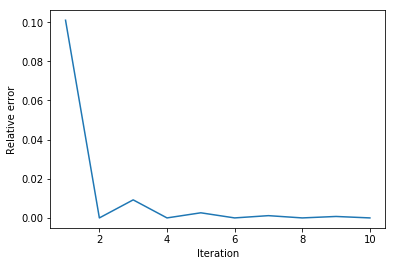

In [6]:
iteration_vec = np.linspace(1,iteration,iteration)
plt.plot(iteration_vec,error_vec)
plt.xlabel('Iteration')
plt.ylabel('Relative error')
plt.show()